# Задание

Рассмотреть варианты Байесовского классификатора, представленные в sklearn, и найти тот, что будет лучше всего (равномерно) предсказывать все классы по тексту (`./data/financial-news-sentiment.xlsx`).
* Нужно построить распараллеленный препроцессинг на основе Wordnet lematizer.

Виды Байесовских классификаторов в sklearn:
1) Gaussian Naive Bayes (**GaussianNB**).
2) Naive Bayes classifier for multinomial models (**MultinomialNB**).
3) Naive Bayes classifier for multivariate Bernoulli models (**BernoulliNB**).
4) The Complement Naive Bayes classifier (**ComplementNB**).

# Настройки/Импорты

Версии важных модулей:
* pandas==2.1.1
* numpy==1.26.2

In [77]:
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import psutil # для просмотра числа потоков на cpu
from pandarallel import pandarallel # для параллельного запуска кода на cpu
from tqdm import tqdm # для отслеживания прогресса

import matplotlib.pyplot as plt # для построения графиков
from wordcloud import WordCloud # для построения изображения с самыми часто встречаемыми словами (помогает в определении дополнительных стоп-слов)
from matplotlib.colors import LinearSegmentedColormap # для создания своего cmap

import re # для регулярных выражений
import nltk # для работы с текстом
from nltk.stem import WordNetLemmatizer # лемматизатор (для английского)
from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # для токенизации строки

from sklearn.feature_extraction.text import TfidfVectorizer # векторизатор текста
from sklearn.model_selection import train_test_split # для разбиения на обучающую и тестовую выборку
from sklearn.utils import resample # для upsample и downsample данных (выравнивание классов)

from sklearn.model_selection import ShuffleSplit # для кросс-валидации
# ShuffleSplit - Кросс-валидатор случайной перестановки
# Дает индексы для разбиения данных на обучающий и тестовый наборы.
# Примечание: в отличие от других стратегий кросс-валидации, случайное разбиение не гарантирует,
# что все складки будут разными, хотя для больших наборов данных это вполне вероятно.
from sklearn.model_selection import GridSearchCV # для перебора параметров

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB # Байесовские классификаторы 

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay # для оценки качества предсказаний

import pickle # для сохранения и загрузки объектов

import warnings # для обработки предупреждений
warnings.simplefilter(action='ignore', category=FutureWarning) # игнорируем FutureWarning

In [92]:
DATA_DIR = "./data/" # путь до папки с данными
MODELS_DIR = "./models/" # путь до папки с моделями
RANDOM_STATE = 42 # число для задания случайности
CLEANING_VARS = ["none", "trash", "stop_words", "punctuation", "digits", "all"] # варианты очистки текста
ADD_STOP_WORDS = ["ca", "n't", "'s"] # дополнительные стоп-слова

MIN_DF = 5 # если float — при построении vocabulary векторизатора игнорировать слова, у которых частота встречи среди документов меньше заданной пропорции (int — абсолютное значение)
MAX_DF = 0.5 # если float — при построении vocabulary векторизатора игнорировать слова, у которых частота встречи среди документов больше заданной пропорции (int — абсолютное значение)
MAX_FEATURES = 15000 # максимальное число фичей (токенов) в словаре векторизатора

N_JOBS = 1 # количество потоков для параллельного выполнения некоторых участков кода
VERBOSE = 0 # на сколько подробным должен быть вывод при обучении

TEST_SIZE = 0.2 # размер тестовой выборки
CV_SPLITS = 2 # число разбиений для кросс-валидации

In [65]:
# nltk.download('wordnet') # загрузка дополнительных пакетов для nltk
# nltk.download('punkt') # загрузка дополнительных пакетов для nltk

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False)) # число доступных топоков

Количество доступных потоков:  4


# Предобработка датасета

In [28]:
dataset = pd.read_excel(DATA_DIR + "financial-news-sentiment.xlsx", usecols=[0,1]) # считывание excel данных (usecols=[0,1] — только первые две колонки)
dataset

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,Bearish
1,$CCL $RCL - Nomura points to bookings weakness...,Bearish
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",Bearish
3,$ESS: BTIG Research cuts to Neutral https://t....,Bearish
4,$FNKO - Funko slides after Piper Jaffray PT cu...,Bearish
...,...,...
12419,Stocks making the biggest moves midday: TD Ame...,Neutral
12420,Stocks making the biggest moves premarket: Fit...,Neutral
12421,Stocks making the biggest moves premarket: Hom...,Neutral
12422,Stocks making the biggest moves premarket: TD ...,Neutral


## Избавляемся от пропущенных данных

In [29]:
dataset = dataset[dataset["text"].notnull()] # оставляем те строки, у которых столбец "text" имеет значение
dataset = dataset[dataset["label"].notnull()] # оставляем те строки, у которых столбец "label" имеет значение

In [30]:
dataset.shape # размер датасета после удаления пропусков

(11934, 2)

## Избавляемся от выбросов

In [31]:
dataset["label"].value_counts()

label
Neutral                                                                                7732
Bullish                                                                                2397
Bearish                                                                                1788
 answered by @Jess_Shankleman https://t.co/V7NeutralzSgbNnc"                              1
 well                                                                                     1
 in all likelihood                                                                        1
 theyвЂ™re finallyвЂ¦ https://t.co/sVmzdrN4ho"                                            1
Bullish3Bullish.98 points                                                                 1
 breaking 7 consecutive up weeksвЂ¦ https://t.co/kBearish4JSxx56R"                        1
 the #NasdaqFam is setting the pace andвЂ¦ https://t.co/hFU6Y6EUBullisht"                 1
 celebrate 'Drygiving' with these non-boozy alternatives.                 

In [32]:
dataset = dataset[dataset["label"].isin(["Neutral", "Bullish", "Bearish"])] # оставляем те строки, у которых столбец "label" имеет допустимое значение
dataset.shape # размер датасета после удаления выбросов

(11917, 2)

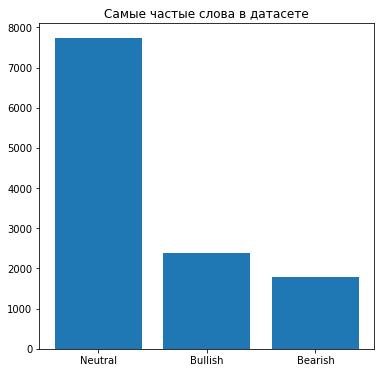

In [33]:
plt.figure(figsize=(6,6)) # задание размера графика
plt.bar(dataset["label"].value_counts().index, dataset["label"].value_counts()) # построение столбатой диаграммы по данным (dataset["label"].value_counts().index — колонки, dataset["label"].value_counts() — их значения)
plt.title("Самые частые слова в датасете") # название графика
plt.show() # вывод графика

В данных наблюдается дисбаланс по классам, его решать будем с помощью метода "upsampling" на этапе векторизации (генерировать дополнительные данные для малопредставленных классов).

##

In [34]:
dataset.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True и перезаписываем существующий датасет)

## Очистка датасета

In [35]:
stop_words = stopwords.words('english') # список стоп-слов для английского языка
for add_stop in ADD_STOP_WORDS: # идём по дополнительным стоп-словам
    stop_words.append(add_stop) # добавляем стоп-слово
stop_words[:10] # первые 10 стоп-слов для английского языка

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [46]:
pandarallel.initialize(progress_bar=True) # запуск в параллельном режиме (с отображением прогресса выполнения)

def clear_data(df: pd.DataFrame, var, columns=["text"], stop_words=[]) -> pd.DataFrame:
    """
    Универсальная параллельная функция для очистки датасета (лишние пробелы можно не удалять, так как word_tokenize их сам уберёт).\n
    Parameters:
        * df: рассматриваемый датасет
        * var: тип очистки
        * columns: столбцы в датасете, что будут очищаться
        * stop_words: какие стоп-слова использовать\n
    Returns:
        * pd.DataFrame: датасет с очищенными столбцами columns
    """
    # импортируем, так как потоки их перестанут видеть
    import re
    # import pymorphy3
    from nltk.tokenize import word_tokenize
    # from nltk.stem import WordNetLemmatizer # лемматизатор (для английского)


    # morph = pymorphy3.MorphAnalyzer() # объект для лемматизации слов
    lemmatizer = WordNetLemmatizer() # объект для лемматизации слов


    for column in columns:
        df[column] = df[column].parallel_apply(lambda text: text.lower()) # приводим к нижнему регистру

        if var in ["trash", "all"]:
            # df[column] = df[column].parallel_apply(lambda text: re.sub('\[\[\w*d*\|', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])
            # df[column] = df[column].parallel_apply(lambda text: re.sub(']', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])

            # df[column] = df[column].parallel_apply(lambda text: re.sub('@\S*', '', text)) # убираем тегирование (например @Soloviev)

            # df[column] = df[column].parallel_apply(lambda text: re.sub('<.*?>', '', text)) # убираем html элементы

            df[column] = df[column].parallel_apply(lambda text: re.sub("http\S*", ' ', text)) # убираем ссылки (например https://t.co/KN1g4AWFIb)


        if var in ["punctuation", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub(r"[,.…?:;¦/\\!@#$#—+=ツ►๑۞۩•«»“”˜°*`\"'™)(<>\[\]%$&]", '', text)) # удаляем различную пунктуацию
            df[column] = df[column].parallel_apply(lambda text: re.sub("-", ' ', text)) # заменяем тире на пробел


        if var in ["digits", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub('\d', '', text)) # удаляем цифры


        df[column] = df[column].parallel_apply(lambda text: word_tokenize(text)) # разбиваем текст на токены
        # df[column] = df[column].parallel_apply(lambda text: [morph.parse(word)[0].normal_form for word in text]) # приводим слова к нормальной форме (если она у них есть, иначе они остаются без изменения)
        df[column] = df[column].parallel_apply(lambda text: [lemmatizer.lemmatize(word) for word in text]) # лемматизируем слова

        if var in ["stop_words", "all"]:
            df[column] = df[column].parallel_apply(lambda text: [word for word in text if word not in stop_words]) # удаляем стоп-слова

        df[column] = df[column].parallel_apply(lambda text: ' '.join(text)) # собираем токены обратно в строку
        df[column] = df[column].astype('string') # приводим колонку к типу строки (чтобы у записей не было начальных и конечных кавычек)

        # df = df[df[column].notnull()] # оставляем те строки, у которых рассматриваемый столбец имеет значение
        df = df[df[column] != ""] # оставляем те строки, данные в которых не занулились

    df.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True и перезаписываем существующий датасет)
    return df # возвращаем обработанный датасет

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    dataset_cleared = clear_data(dataset.copy(), var, ["text"], stop_words) # проводим очистку датасета
    dataset_cleared.to_csv(DATA_DIR + f"data_{var}.csv", sep=";", index=False) # сохраняем полученный датасет (index=False — без сохранения индексов)

После очистки ещё несколько строк были удалены из датасета, так как они сократились до пустой строки.

## Отображение самых частых слов в датасете

Помогает определить дополнительные стоп-слова.

In [3]:
dataset_cleared = pd.read_csv(DATA_DIR + "data_all.csv",  sep=';', encoding='utf8', index_col=False) # считывание данных
dataset_cleared

,text,label
0,bynd jpmorgan reel expectation beyond meat,Bearish
1,ccl rcl nomura point booking weakness carnival...,Bearish
2,cx cemex cut credit suisse jp morgan weak buil...,Bearish
3,es btig research cut neutral,Bearish
4,fnko funko slide piper jaffray pt cut,Bearish
...,...,...
11820,stock making biggest move midday td ameritrade...,Neutral
11821,stock making biggest move premarket fitbit xer...,Neutral
11822,stock making biggest move premarket home depot...,Neutral
11823,stock making biggest move premarket td ameritr...,Neutral


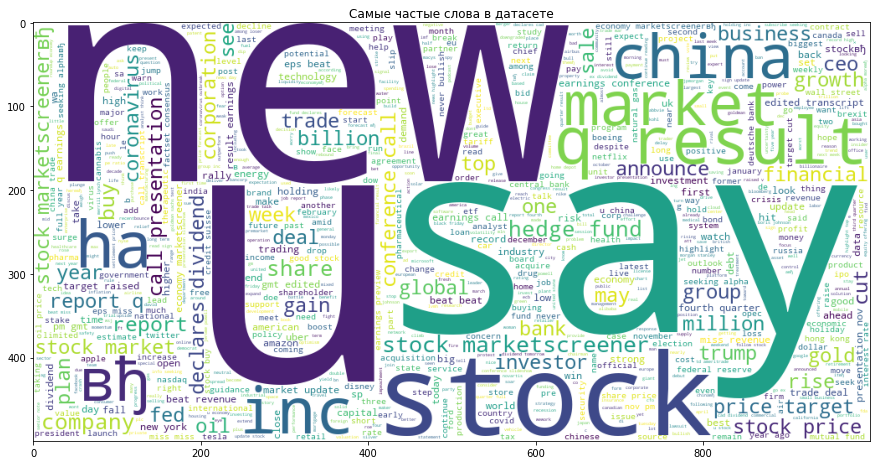

In [51]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=RANDOM_STATE) # создание WordCloud объекта
wordcloud.generate(" ".join(dataset_cleared["text"])) # отправляем в WordCloud весь текст из датасета

plt.figure(figsize=(15,10)) # задание размера графика
plt.imshow(wordcloud) # отображение картинки
plt.title("Самые частые слова в датасете")
plt.show() # вывод графика

# Обучение моделей

In [44]:
data = {} # словарь под все варианты обработки вида
# {"var 1":
#   {
#     "X_train": [...],
#     "X_test": [...],
#     "y_train": [...],
#     "y_test": [...],
#     "vectorizer": векторизатор
#   }, ...
# }

In [75]:
results = {} # словарь под полученные результаты классификаторов
# {"classifier 1":
#   {
#     "var 1": метрика,
#     "var 2": метрика,
#     ...
#   }, ...
# }

In [82]:
custom_cv = ShuffleSplit(n_splits=CV_SPLITS, test_size=TEST_SIZE, random_state=RANDOM_STATE) # кастомный кросс-валидатор ()
# n_splits — число разбиений для кросс-валидации
# test_size — размер тестовой выборки

In [220]:
cmap = LinearSegmentedColormap.from_list("from_red_to_green", [(1, 0.15, 0.15), (0, 0.6, 0)], N=100) # собственная цветовая палитра (числа в формате RGB от 0 до 1 то есть 255/255)

### Векторизация данных (+ upsampling)

In [50]:
for var in CLEANING_VARS: # идём по вариантам обработки
    dataset_cleared = pd.read_csv(f"{DATA_DIR}data_{var}.csv",  sep=";", encoding="utf8", index_col=False) # считывание данных об очищенном датасете

    vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=MIN_DF, max_df=MAX_DF, max_features=MAX_FEATURES) # векторизатор (с ограничениями на построение vocabulary, чтобы вектора были не слишком большие)
    data_X = vectorizer.fit_transform(dataset_cleared["text"]).toarray() # конвертируем документы (текста) в вектора
    print(f"Размерность при варианте обработки '{var}' до: сэмплов — {data_X.shape[0]}, фич — {data_X.shape[1]}.")

    # factorizer = pd.factorize(dataset_cleared["label"]) # перевод строковых таргетов (type: object) в числовой формат (type: int, от 1...)
    # data_y = factorizer[0] # таргеты (уже в числовом формате, под индексом 1 — их названия)
    data_y = dataset_cleared["label"].to_numpy() # берём таргеты (не переводя их в числовой формат)

    max_samples = dataset_cleared["label"].value_counts()[0] # число элементов в наиболее представленном классе
    max_label = dataset_cleared["label"].value_counts().index[0] # название наиболее представленного класса

    # сначала получаем данные о распределении фич для каждого класса, чтобы потом провести их выравнивание (upsampling) 
    data_distribution = {} # словарь под распределение данных по классам
    for label_value in dataset_cleared["label"].unique(): # идём по уникальным таргетам
        data_distribution[label_value] = data_X[data_y == label_value] # записываем в data_distribution TF-IDF вектора, соответствующие рассматриваемому label_value
        
        print(f"    В классе '{label_value}' было {len(data_distribution[label_value])} записей.")

    # после процедуры upsampling, собираем данные обратно в датасет
    print(f"---------------------------------------------------------------------------")
    data_resampled = pd.DataFrame(columns=[*range(data_X.shape[1]), "label"]) # заготовка под DataFrame без дисбаланса классов (слолбцы: data_X.shape[1] фич и "label")
    for label_value in dataset_cleared["label"].unique(): # идём по уникальным таргетам
        data_distribution[label_value] = resample(data_distribution[label_value], n_samples=max_samples, random_state=RANDOM_STATE) # добавляем записи к рассматриваемому таргету до n_samples по соответствующему распределению
        print(f"    В классе '{label_value}' стало {len(data_distribution[label_value])} записей.")

        data_for_label = pd.DataFrame(data_distribution[label_value]) # создаём DataFrame из векторов, соответствующих рассматриваемому таргету
        data_for_label["label"] = label_value # добавляем колонку таргета в DataFrame (у всех строк будет значение рассматриваемого таргета)

        data_resampled = pd.concat([data_resampled, data_for_label]) # соединяем вместе все DataFrame_ы классов

    data_y = data_resampled["label"].values # запоминаем таргеты (array)
    del data_resampled["label"] # в data_resampled (DataFrame) оставляем только вектора фич
    data_X = data_resampled.values # возвращаем фичи к типу array (хоть можно было оставить и DataFrame)

    print(f"Размерность при варианте обработки '{var}' после: сэмплов — {data_X.shape[0]}, фич — {data_X.shape[1]}.")
    print(f"===========================================================================")

    data[var] = {} # заготовка под сплит
    data[var]["X_train"], data[var]["X_test"], data[var]["y_train"], data[var]["y_test"] = train_test_split(data_X, data_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_y)
    # разбиваем датасет (dataset["source_text"] — данные, dataset["ethno"] — таргеты) на обучающую и тестовую выборки в соотношении TEST_SIZE, при этом пропорция таргетов должна быть одинаковой (stratify=data_y) в обоих выборках
    data[var]["vectorizer"] = vectorizer # векторизатор

Размерность при варианте обработки 'none' до: сэмплов — 11917, фич — 3276.
    В классе 'Bearish' было 1788 записей.
    В классе 'Bullish' было 2397 записей.
    В классе 'Neutral' было 7732 записей.
---------------------------------------------------------------------------
    В классе 'Bearish' стало 7732 записей.
    В классе 'Bullish' стало 7732 записей.
    В классе 'Neutral' стало 7732 записей.
Размерность при варианте обработки 'none' после: сэмплов — 23196, фич — 3276.
Размерность при варианте обработки 'trash' до: сэмплов — 11826, фич — 3272.
    В классе 'Bearish' было 1782 записей.
    В классе 'Bullish' было 2361 записей.
    В классе 'Neutral' было 7683 записей.
---------------------------------------------------------------------------
    В классе 'Bearish' стало 7683 записей.
    В классе 'Bullish' стало 7683 записей.
    В классе 'Neutral' стало 7683 записей.
Размерность при варианте обработки 'trash' после: сэмплов — 23049, фич — 3272.
Размерность при варианте обраб

In [118]:
data["all"] # пример содержимого данных

{'X_train': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'X_test': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y_train': array(['Neutral', 'Bullish', 'Neutral', ..., 'Neutral', 'Bullish',
        'Neutral'], dtype=object),
 'y_test': array(['Bearish', 'Neutral', 'Neutral', ..., 'Neutral', 'Neutral',
        'Bearish'], dtype=object),
 'vectorizer': TfidfVectorizer(max_df=0.5, max_features=15000, min_df=5)}

### Вспомогательные функции

In [93]:
def model_train(model, params, X_train, y_train, cv, n_jobs=N_JOBS, verbose=VERBOSE, scoring="f1_macro") -> GridSearchCV:
    """
    Универсальная функция для обучения классификаторов.\n
    Parameters:
        * model: классификатор
        * params: параметры для перебора в GreedSearch
        * X_train: данные для обучения
        * y_train: таргеты для обучения
        * cv: метод для кросс-валидации
        * n_jobs: количество потоков для распараллеливания
        * verbose: на сколько подробным должен быть вывод при обучении
        * scoring: метрика для выбора лучшей модели\n
    Returns:
        * GridSearchCV: объект, содержащий
    """
    greed_search = GridSearchCV(model, params, cv=cv , scoring=scoring, n_jobs=n_jobs, verbose=verbose) # передаём параметры в GridSearchCV

    greed_search.fit(X_train, y_train) # обучаем модель

    return greed_search # возвращаем обученный классификатор

In [94]:
def model_save(model, file_name):
    """
    Функция для сохранения модели.\n
    Parameters:
        * model: классификатор, что нужно сохранить
        * file_name: путь, куда сохранять\n
    Returns:
        * None
    """
    with open(file_name, 'wb') as f: # открытие файла для записи ('w')
        pickle.dump(model, f) # сохраняем модель

In [193]:
def investigation(model, params, data, model_name, cv) -> dict:
    """
    Функция для сохранения модели.\n
    Parameters:
        * model: общая модель, с которой будет взаимодействие
        * params: параметры для перебора при обучении
        * data: данные в формате словаря вида {"вариант_обработки": {"X_train": [...], "X_test": [...], "y_train": [...], "y_test": [...]}, ...}
        * model_name: название модели
        * cv: параметры кросс-валидации\n
    Returns:
        * dict: словарь вида {"вариант_обработки": f1 macro score, ...}
    """
    results = {} # словарь под результаты обучения (f1 score для вариантов обработки)
    
    for var in CLEANING_VARS: # идём по вариантам обработки
        model_gs = model_train(model, params, data[var]["X_train"], data[var]["y_train"], cv) # вызываем функцию обучения
        best_model = model_gs.best_estimator_ # берём лучшую модель

        model_save(best_model, f"{MODELS_DIR}{model_name}_{var}.pkl") # сохраняем лучшую модель (с указанием варианта очистки текста)

        print(f"Результаты для варианта обработки '{var}':")

        y_pred = best_model.predict(data[var]["X_test"]) # делаем предсказание на тестовой выборке с помощью обученной модели
        results[var] = f1_score(data[var]["y_test"], y_pred, average="macro", zero_division=0) # считаем и сохраняем посчитанный f1 score ("macro" — по всем класса, без учёта дисбаланса) (zero_division=0 — деление на ноль заменять нулём)
        print(classification_report(data[var]["y_test"], y_pred, zero_division=0)) # выводим основные метрики, такие как precision, recall, f1-score, accuracy (zero_division=0 — деление на ноль заменять нулём)
        
        fig, ax = plt.subplots(figsize=(6,6)) # создание "фигуры"
        ConfusionMatrixDisplay(confusion_matrix(data[var]["y_test"], y_pred), display_labels=np.unique(data_y)).plot(ax=ax) # строим confusion matrix (стоит обратить внимание на display_labels, они могут не совпасть...)
        # fig.autofmt_xdate(rotation=45, ha='right') # поворот подписей на оси OX
        plt.show() # вывод графика
    return results

In [178]:
def compare_results(results, model_name):
    """
    Функция для сравнения качества предсказаний при различных вариантах.\n
    Parameters:
        * results: словарь вида {"вариант": значение, ...}
        * model_name: название модели\n
    Returns:
        * None
    """

    plt.figure(figsize=(8,8)) # задание размера графика
    sorted_results = dict(sorted(results.items(), key=lambda x: x[1])) # сортируем элементы словаря в порядке увеличения значения
    
    plt.scatter(list(sorted_results.keys()), list(sorted_results.values()), s=100, color=cmap(np.linspace(0, 1, len(sorted_results)))) # разноцветные точки
    plt.plot(list(sorted_results.keys()), list(sorted_results.values())) # соединяющая линия

    plt.title(f"Сравнение f1 macro score для модели {model_name}") # название графика
    plt.xlabel("Вариант обработки текста") # подпись по оси x
    plt.ylabel("F1 macro score") # подпись по оси y
    plt.show() # вывод графика

## 1) GaussianNB

In [195]:
params = [{
    "priors": [None], # априорные вероятности классов (если None — назначаются по входным данным)
    "var_smoothing": [1e-9] # Portion of the largest variance of all features that is added to variances for calculation stability.
}]

model_name = "GaussianNB" # название модели
model = GaussianNB() # модель

Результаты для варианта обработки 'none':
              precision    recall  f1-score   support

     Bearish       0.64      0.95      0.76      1546
     Bullish       0.73      0.75      0.74      1547
     Neutral       0.96      0.46      0.62      1547

    accuracy                           0.72      4640
   macro avg       0.78      0.72      0.71      4640
weighted avg       0.78      0.72      0.71      4640



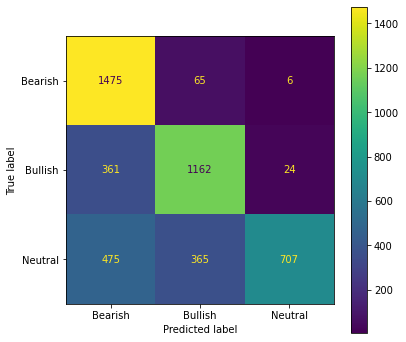

Результаты для варианта обработки 'trash':
              precision    recall  f1-score   support

     Bearish       0.63      0.96      0.76      1536
     Bullish       0.73      0.73      0.73      1537
     Neutral       0.97      0.45      0.61      1537

    accuracy                           0.71      4610
   macro avg       0.77      0.71      0.70      4610
weighted avg       0.77      0.71      0.70      4610



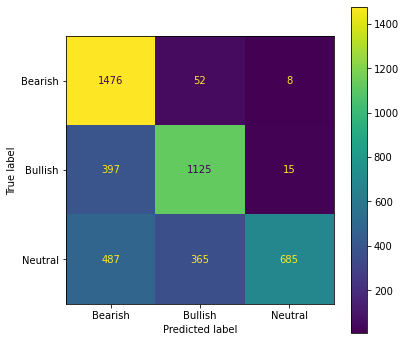

Результаты для варианта обработки 'stop_words':
              precision    recall  f1-score   support

     Bearish       0.63      0.95      0.76      1546
     Bullish       0.73      0.74      0.73      1547
     Neutral       0.96      0.46      0.62      1547

    accuracy                           0.72      4640
   macro avg       0.77      0.72      0.70      4640
weighted avg       0.77      0.72      0.70      4640



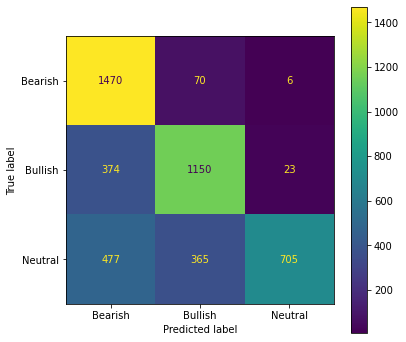

Результаты для варианта обработки 'punctuation':
              precision    recall  f1-score   support

     Bearish       0.63      0.96      0.76      1546
     Bullish       0.74      0.73      0.74      1546
     Neutral       0.97      0.48      0.64      1547

    accuracy                           0.72      4639
   macro avg       0.78      0.72      0.71      4639
weighted avg       0.78      0.72      0.71      4639



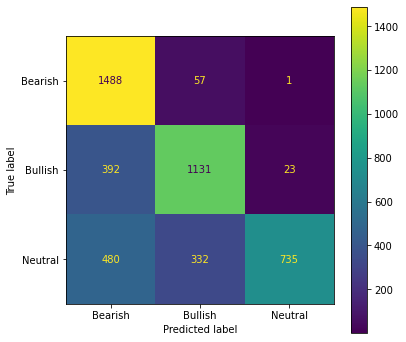

Результаты для варианта обработки 'digits':
              precision    recall  f1-score   support

     Bearish       0.65      0.95      0.77      1546
     Bullish       0.72      0.78      0.75      1547
     Neutral       0.96      0.45      0.61      1547

    accuracy                           0.73      4640
   macro avg       0.78      0.73      0.71      4640
weighted avg       0.78      0.73      0.71      4640



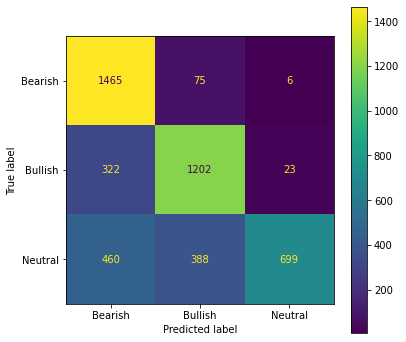

Результаты для варианта обработки 'all':
              precision    recall  f1-score   support

     Bearish       0.62      0.95      0.75      1536
     Bullish       0.72      0.72      0.72      1537
     Neutral       0.96      0.45      0.61      1537

    accuracy                           0.71      4610
   macro avg       0.77      0.71      0.69      4610
weighted avg       0.77      0.71      0.69      4610



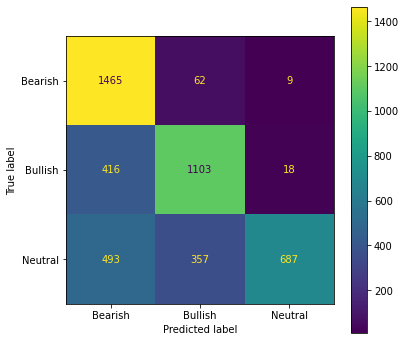

In [196]:
results[model_name] = investigation(model, params, data, model_name, custom_cv) # обучаем модель, перебираем параметры, сохраняем, оцениванием и запоминаем результатa

Сравнение полученных F1 score:

In [197]:
max(results[model_name].items(), key=lambda x: x[1]) # поиск максимального значения в словаре ([1] — по значению, а не ключу)

('punctuation', 0.7123804394295905)

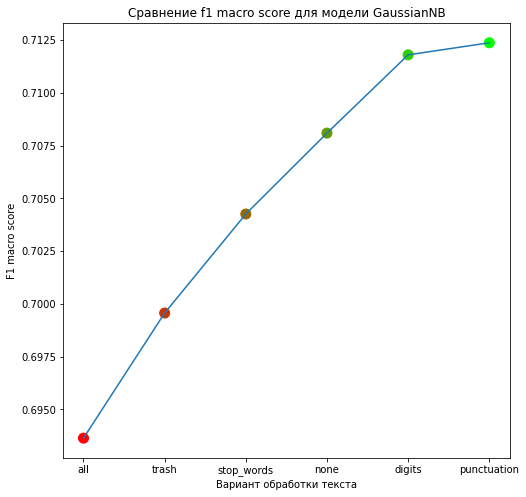

In [198]:
compare_results(results[model_name], model_name) # сравнение получившихся метрик

## 2) MultinomialNB

In [199]:
params = [{
    "alpha": [1.0], # Additive (Laplace/Lidstone) smoothing parameter (set alpha=0 and force_alpha=True, for no smoothing).
    "force_alpha": [True], # If False and alpha is less than 1e-10, it will set alpha to 1e-10. If True, alpha will remain unchanged. This may cause numerical errors if alpha is too close to 0.
    "fit_prior": [True], # нужно ли считать априорные вероятности классов (если False — используется равномерное распрежедение)
    "class_prior": [None] # априорные вероятности классов (если None — назначаются по входным данным)
}]

model_name = "MultinomialNB" # название модели
model = MultinomialNB() # модель

Результаты для варианта обработки 'none':
              precision    recall  f1-score   support

     Bearish       0.81      0.83      0.82      1546
     Bullish       0.83      0.82      0.82      1547
     Neutral       0.81      0.80      0.80      1547

    accuracy                           0.82      4640
   macro avg       0.82      0.82      0.82      4640
weighted avg       0.82      0.82      0.82      4640



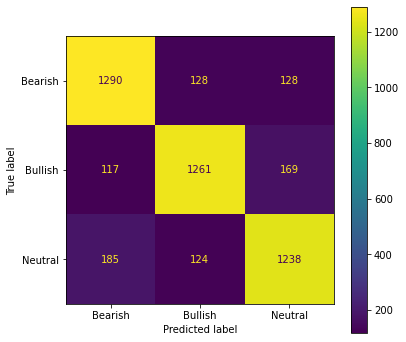

Результаты для варианта обработки 'trash':
              precision    recall  f1-score   support

     Bearish       0.81      0.85      0.83      1536
     Bullish       0.80      0.84      0.82      1537
     Neutral       0.85      0.77      0.81      1537

    accuracy                           0.82      4610
   macro avg       0.82      0.82      0.82      4610
weighted avg       0.82      0.82      0.82      4610



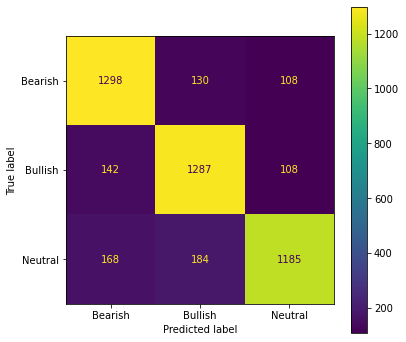

Результаты для варианта обработки 'stop_words':
              precision    recall  f1-score   support

     Bearish       0.80      0.83      0.82      1546
     Bullish       0.80      0.80      0.80      1547
     Neutral       0.81      0.78      0.79      1547

    accuracy                           0.80      4640
   macro avg       0.80      0.80      0.80      4640
weighted avg       0.80      0.80      0.80      4640



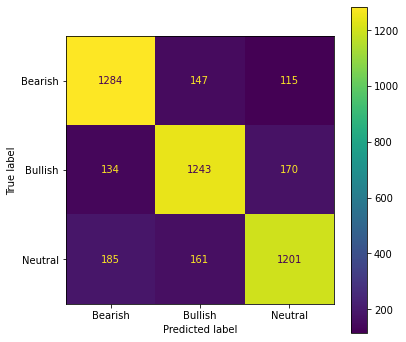

Результаты для варианта обработки 'punctuation':
              precision    recall  f1-score   support

     Bearish       0.80      0.84      0.82      1546
     Bullish       0.82      0.82      0.82      1546
     Neutral       0.83      0.79      0.81      1547

    accuracy                           0.81      4639
   macro avg       0.82      0.81      0.81      4639
weighted avg       0.82      0.81      0.81      4639



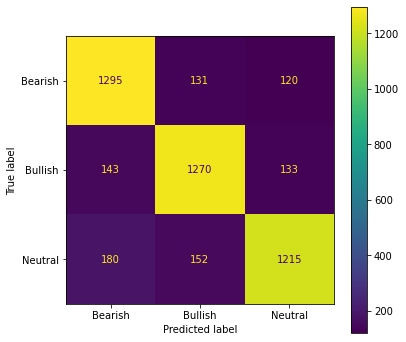

Результаты для варианта обработки 'digits':
              precision    recall  f1-score   support

     Bearish       0.81      0.83      0.82      1546
     Bullish       0.83      0.82      0.82      1547
     Neutral       0.80      0.79      0.80      1547

    accuracy                           0.81      4640
   macro avg       0.81      0.81      0.81      4640
weighted avg       0.81      0.81      0.81      4640



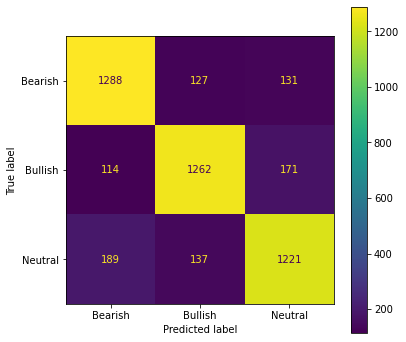

Результаты для варианта обработки 'all':
              precision    recall  f1-score   support

     Bearish       0.80      0.82      0.81      1536
     Bullish       0.78      0.81      0.80      1537
     Neutral       0.83      0.78      0.80      1537

    accuracy                           0.80      4610
   macro avg       0.80      0.80      0.80      4610
weighted avg       0.80      0.80      0.80      4610



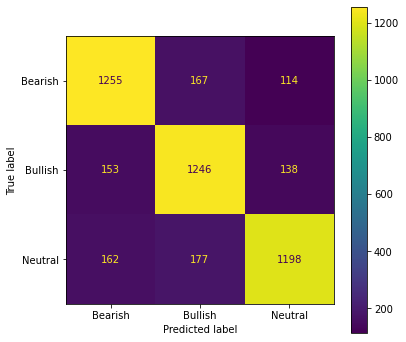

In [200]:
results[model_name] = investigation(model, params, data, model_name, custom_cv) # обучаем модель, перебираем параметры, сохраняем, оцениванием и запоминаем результатa

Сравнение полученных F1 score:

In [201]:
max(results[model_name].items(), key=lambda x: x[1]) # поиск максимального значения в словаре ([1] — по значению, а не ключу)

('trash', 0.8175462122909471)

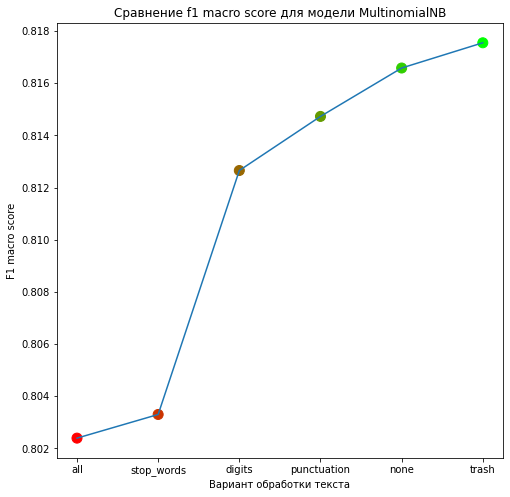

In [202]:
compare_results(results[model_name], model_name) # сравнение получившихся метрик

## 3) BernoulliNB

In [203]:
params = [{
    "alpha": [1.0], # Additive (Laplace/Lidstone) smoothing parameter (set alpha=0 and force_alpha=True, for no smoothing).
    "force_alpha": [True], # If False and alpha is less than 1e-10, it will set alpha to 1e-10. If True, alpha will remain unchanged. This may cause numerical errors if alpha is too close to 0.
    "binarize": [0.0], # порог для бинаризации фич (преобразования в bool) (если None, предполагается, что входные данные это уже двоичные вектора)
    "fit_prior": [True], # нужно ли считать априорные вероятности классов (если False — используется равномерное распрежедение)
    "class_prior": [None] # априорные вероятности классов (если None — назначаются по входным данным)
}]

model_name = "BernoulliNB" # название модели
model = BernoulliNB() # модель

Результаты для варианта обработки 'none':
              precision    recall  f1-score   support

     Bearish       0.83      0.82      0.83      1546
     Bullish       0.81      0.80      0.81      1547
     Neutral       0.79      0.80      0.79      1547

    accuracy                           0.81      4640
   macro avg       0.81      0.81      0.81      4640
weighted avg       0.81      0.81      0.81      4640



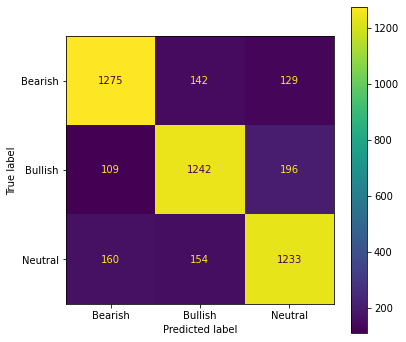

Результаты для варианта обработки 'trash':
              precision    recall  f1-score   support

     Bearish       0.82      0.83      0.83      1536
     Bullish       0.80      0.84      0.82      1537
     Neutral       0.83      0.79      0.81      1537

    accuracy                           0.82      4610
   macro avg       0.82      0.82      0.82      4610
weighted avg       0.82      0.82      0.82      4610



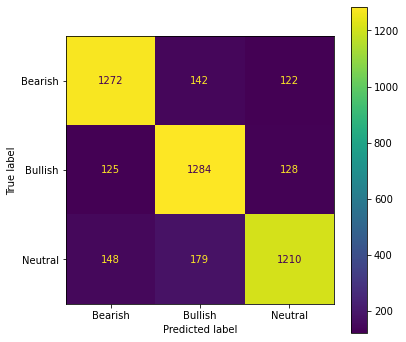

Результаты для варианта обработки 'stop_words':
              precision    recall  f1-score   support

     Bearish       0.82      0.81      0.81      1546
     Bullish       0.79      0.80      0.79      1547
     Neutral       0.79      0.79      0.79      1547

    accuracy                           0.80      4640
   macro avg       0.80      0.80      0.80      4640
weighted avg       0.80      0.80      0.80      4640



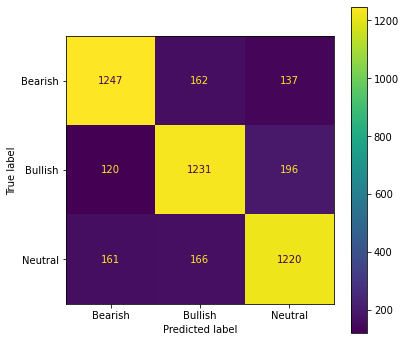

Результаты для варианта обработки 'punctuation':
              precision    recall  f1-score   support

     Bearish       0.83      0.82      0.83      1546
     Bullish       0.81      0.81      0.81      1546
     Neutral       0.80      0.81      0.80      1547

    accuracy                           0.81      4639
   macro avg       0.81      0.81      0.81      4639
weighted avg       0.81      0.81      0.81      4639



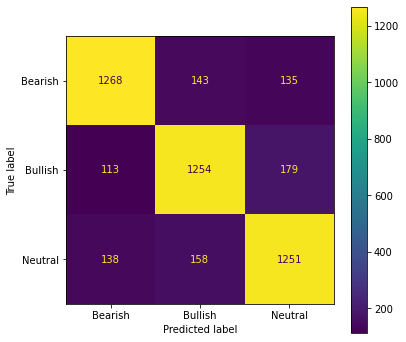

Результаты для варианта обработки 'digits':
              precision    recall  f1-score   support

     Bearish       0.82      0.81      0.82      1546
     Bullish       0.80      0.80      0.80      1547
     Neutral       0.79      0.79      0.79      1547

    accuracy                           0.80      4640
   macro avg       0.80      0.80      0.80      4640
weighted avg       0.80      0.80      0.80      4640



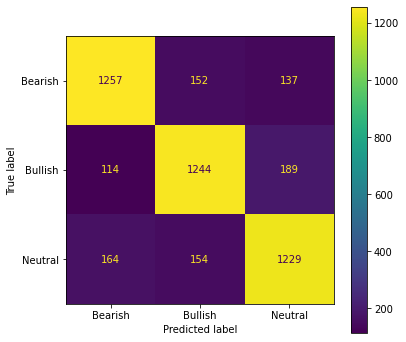

Результаты для варианта обработки 'all':
              precision    recall  f1-score   support

     Bearish       0.82      0.80      0.81      1536
     Bullish       0.77      0.82      0.80      1537
     Neutral       0.82      0.79      0.81      1537

    accuracy                           0.80      4610
   macro avg       0.80      0.80      0.80      4610
weighted avg       0.80      0.80      0.80      4610



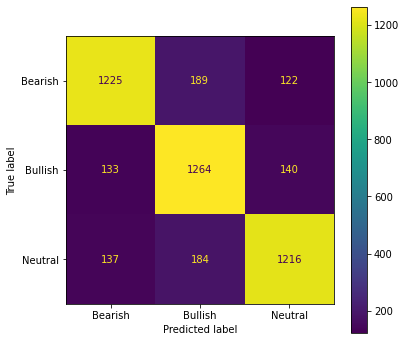

In [204]:
results[model_name] = investigation(model, params, data, model_name, custom_cv) # обучаем модель, перебираем параметры, сохраняем, оцениванием и запоминаем результатa

Сравнение полученных F1 score:

In [205]:
max(results[model_name].items(), key=lambda x: x[1]) # поиск максимального значения в словаре ([1] — по значению, а не ключу)

('trash', 0.8168312977651722)

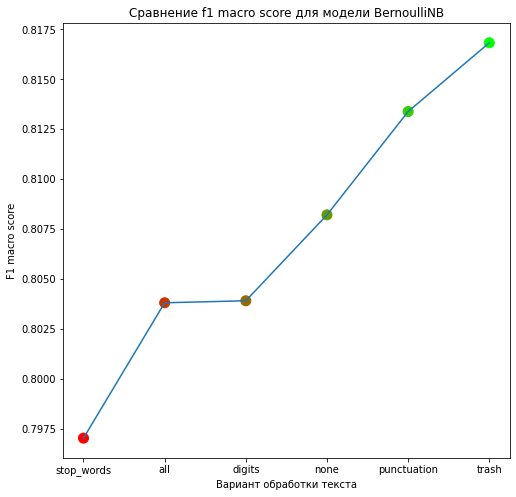

In [206]:
compare_results(results[model_name], model_name) # сравнение получившихся метрик

## 4) ComplementNB

In [207]:
params = [{
    "alpha": [1.0], # Additive (Laplace/Lidstone) smoothing parameter (set alpha=0 and force_alpha=True, for no smoothing).
    "force_alpha": [True], # If False and alpha is less than 1e-10, it will set alpha to 1e-10. If True, alpha will remain unchanged. This may cause numerical errors if alpha is too close to 0.
    "fit_prior": [True], # нужно ли считать априорные вероятности классов (если False — используется равномерное распрежедение)
    "class_prior": [None], # априорные вероятности классов (если None — назначаются по входным данным)
    "norm": [False] # выполняется ли вторичная нормализация весов
}]

model_name = "ComplementNB" # название модели
model = ComplementNB() # модель

Результаты для варианта обработки 'none':
              precision    recall  f1-score   support

     Bearish       0.81      0.82      0.82      1546
     Bullish       0.82      0.79      0.81      1547
     Neutral       0.78      0.80      0.79      1547

    accuracy                           0.81      4640
   macro avg       0.81      0.81      0.81      4640
weighted avg       0.81      0.81      0.81      4640



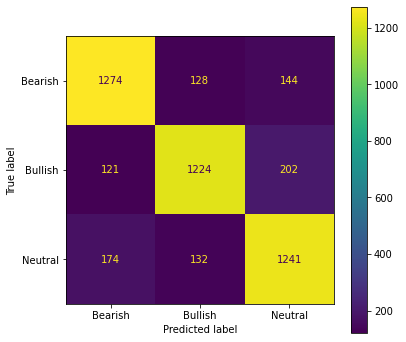

Результаты для варианта обработки 'trash':
              precision    recall  f1-score   support

     Bearish       0.80      0.83      0.82      1536
     Bullish       0.80      0.82      0.81      1537
     Neutral       0.82      0.78      0.80      1537

    accuracy                           0.81      4610
   macro avg       0.81      0.81      0.81      4610
weighted avg       0.81      0.81      0.81      4610



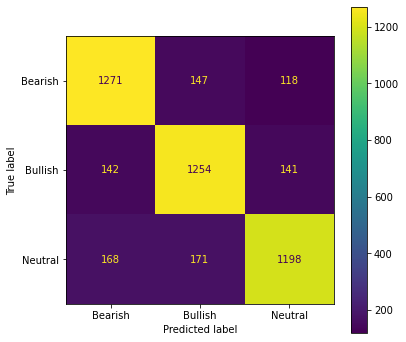

Результаты для варианта обработки 'stop_words':
              precision    recall  f1-score   support

     Bearish       0.80      0.82      0.81      1546
     Bullish       0.80      0.79      0.80      1547
     Neutral       0.79      0.78      0.78      1547

    accuracy                           0.80      4640
   macro avg       0.80      0.80      0.80      4640
weighted avg       0.80      0.80      0.80      4640



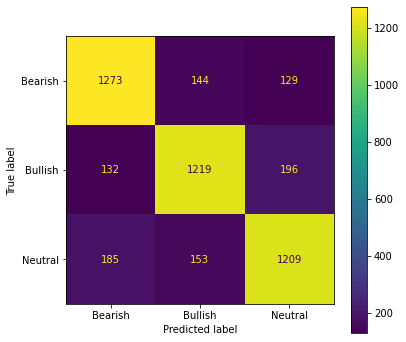

Результаты для варианта обработки 'punctuation':
              precision    recall  f1-score   support

     Bearish       0.80      0.83      0.82      1546
     Bullish       0.83      0.81      0.82      1546
     Neutral       0.81      0.79      0.80      1547

    accuracy                           0.81      4639
   macro avg       0.81      0.81      0.81      4639
weighted avg       0.81      0.81      0.81      4639



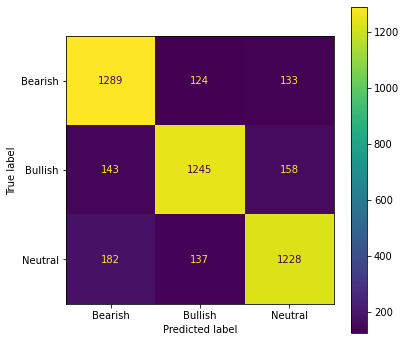

Результаты для варианта обработки 'digits':
              precision    recall  f1-score   support

     Bearish       0.82      0.82      0.82      1546
     Bullish       0.83      0.80      0.81      1547
     Neutral       0.78      0.80      0.79      1547

    accuracy                           0.81      4640
   macro avg       0.81      0.81      0.81      4640
weighted avg       0.81      0.81      0.81      4640



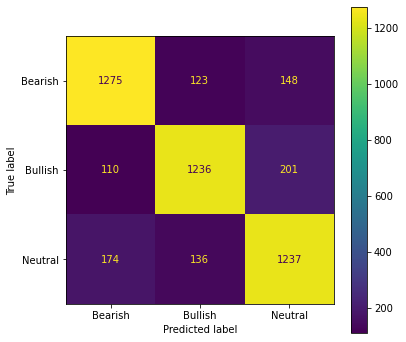

Результаты для варианта обработки 'all':
              precision    recall  f1-score   support

     Bearish       0.79      0.81      0.80      1536
     Bullish       0.78      0.79      0.79      1537
     Neutral       0.80      0.78      0.79      1537

    accuracy                           0.79      4610
   macro avg       0.79      0.79      0.79      4610
weighted avg       0.79      0.79      0.79      4610



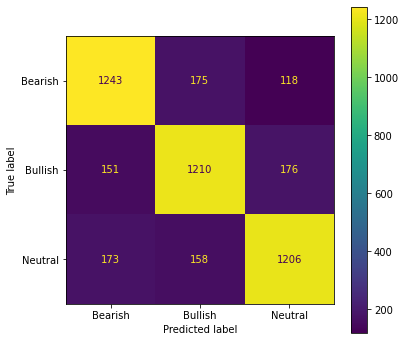

In [208]:
results[model_name] = investigation(model, params, data, model_name, custom_cv) # обучаем модель, перебираем параметры, сохраняем, оцениванием и запоминаем результатa

Сравнение полученных F1 score:

In [209]:
max(results[model_name].items(), key=lambda x: x[1]) # поиск максимального значения в словаре ([1] — по значению, а не ключу)

('punctuation', 0.810908314478851)

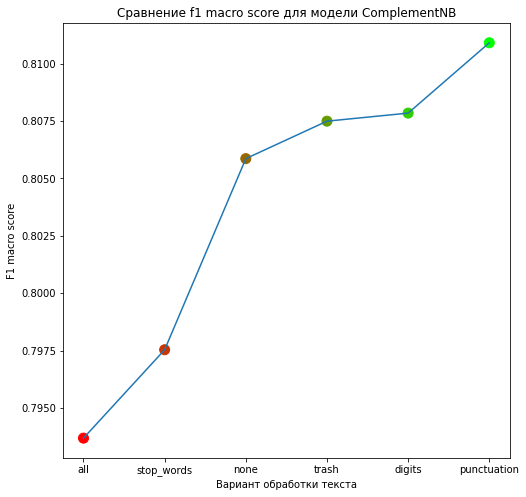

In [210]:
compare_results(results[model_name], model_name) # сравнение получившихся метрик

# Выводы

In [228]:
pd.DataFrame(results).style.background_gradient(cmap=cmap, axis=1).set_properties(**{'color': 'black'}) # сравнение вариантов по строке (варианту предобработки текста)

,GaussianNB,MultinomialNB,BernoulliNB,ComplementNB
none,0.708099,0.816579,0.808211,0.805864
trash,0.699567,0.817546,0.816831,0.807495
stop_words,0.704261,0.803302,0.797026,0.797541
punctuation,0.712380,0.814724,0.813387,0.810908
digits,0.711808,0.812651,0.803906,0.807846
all,0.693636,0.802395,0.803806,0.793693


In [229]:
pd.DataFrame(results).style.background_gradient(cmap=cmap, axis=0).set_properties(**{'color': 'black'}) # сравнение вариантов по столбцу (типу классификатора)

,GaussianNB,MultinomialNB,BernoulliNB,ComplementNB
none,0.708099,0.816579,0.808211,0.805864
trash,0.699567,0.817546,0.816831,0.807495
stop_words,0.704261,0.803302,0.797026,0.797541
punctuation,0.712380,0.814724,0.813387,0.810908
digits,0.711808,0.812651,0.803906,0.807846
all,0.693636,0.802395,0.803806,0.793693


In [244]:
pd.DataFrame(results).max(axis=0) # максимальный f1 score по классификаторам

GaussianNB       0.712380
MultinomialNB    0.817546
BernoulliNB      0.816831
ComplementNB     0.810908
dtype: float64

In [251]:
pd.DataFrame(results).idmax(axis=1) # максимальный f1 score по типу обработки

none           0.816579
trash          0.817546
stop_words     0.803302
punctuation    0.814724
digits         0.812651
all            0.803806
dtype: float64

С данным датасетом все модели справились хорошо, ни у одной F1 macro score не опустился ниже 0.69. Стоит также отметить следующие моменты:
* Лучшего всего себя показал **MultinomialNB** с вариантом обработки "**trash**", то есть когда удалялись только субъективно мусорные символы. F1 score при таком варианте достиг **0.817546**.
* BernoulliNB и ComplementNB показали результаты чуть слабее, чем MultinomialNB.
* Хуже всего себя проявил GaussianNB, причём при всех вариантах предобработки текста, F1 score ~ 0.7.

Среди вариантов предобработки:
* Лучшие очистки — "trash", "punctuation", "none", "digits". Они имеют приблизительно одинаковые результаты.
* Следом идёт удаление только стоп-слов ("stop_words").
* Наихудшим же оказалась комбинация всех вариантов очисток ("all").
